<a href="https://colab.research.google.com/github/yohanesnuwara/spatial-prediction/blob/main/PoroAI_AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Spatial Prediction of Porosity from Seismic Impedance using AutoML

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!git clone -q https://github.com/yohanesnuwara/spatial-prediction
import sys
sys.path.append('/content/spatial-prediction')
from functions import *

!pip -q install tpot
import tpot
import joblib

     |████████████████████████████████| 87 kB 3.2 MB/s 
     |████████████████████████████████| 160 kB 37.6 MB/s 
     |████████████████████████████████| 166.7 MB 14 kB/s 


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## 1. Load primary and secondary data

In [2]:
# Well data
filepath = 'https://raw.githubusercontent.com/yohanesnuwara/GeoDataSets/master/12_sample_data.csv'

df = pd.read_csv(filepath)
df = df.iloc[:,1:]
df = df.sample(frac=.3, random_state=73073).reset_index()

df['logPerm'] = np.log10(df['Perm'].values)

df

,index,X,Y,Facies,Porosity,Perm,AI,logPerm
0,72,250.0,50.0,0.0,0.139637,0.347182,4747.274043,-0.459442
1,153,650.0,750.0,0.0,0.170732,10.720560,4535.625583,1.030217
2,258,80.0,669.0,1.0,0.244345,3222.716042,2696.102930,3.508222
3,56,200.0,150.0,0.0,0.167125,3.042590,5500.997419,0.483243
4,303,60.0,929.0,1.0,0.216253,400.298484,3959.934912,2.602384
...,...,...,...,...,...,...,...,...
139,462,260.0,589.0,1.0,0.192244,122.721296,2841.634370,2.088920
140,393,190.0,59.0,0.0,0.147362,0.325878,5027.967967,-0.486945
141,466,90.0,629.0,1.0,0.231513,1291.740413,2559.454305,3.111175
142,300,190.0,889.0,1.0,0.219072,3462.014918,3666.595641,3.539329


In [3]:
# Seismic data
filepath = 'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/AI_grid.csv'

seismic = np.loadtxt(filepath, delimiter=',')

seismic

array([[6250.52964553, 6062.08826761, 5729.68846667, ..., 5575.57996327,
        5813.09922552, 5742.13184937],
       [5771.988716  , 5597.64187131, 5521.96027416, ..., 6053.16212045,
        6359.1226083 , 5717.67473708],
       [6078.43691485, 5616.30885698, 6131.16745175, ..., 6086.88555663,
        6200.05621339, 6372.99092232],
       ...,
       [4094.71764802, 4517.56039725, 4174.15823958, ..., 5667.54345496,
        5750.18330484, 5436.34525771],
       [3721.34050381, 3873.66647872, 3620.96092963, ..., 5289.81801174,
        5846.24960591, 5422.01858539],
       [3584.05016736, 3617.29178159, 3484.38060765, ..., 5763.37885025,
        5453.69698383, 5360.78233546]])

## 2. Make plots

In [4]:
# Make dataframe for primary data
primary_df = df[['X', 'Y', 'Porosity']]

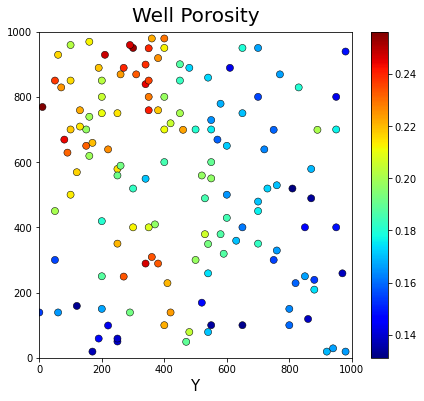

In [5]:
# Make scatter plot of well porosity
plt.figure(figsize=(7,6))
plt.scatter(primary_df.X, primary_df.Y, c=primary_df.Porosity, 
            s=50, linewidth=0.5, edgecolor='black', cmap='jet')
plt.colorbar()
plt.xlabel('X', size=15)
plt.xlabel('Y', size=15)
plt.title('Well Porosity', size=20, pad=10)
plt.xlim(0,1000); plt.ylim(0,1000)
plt.show()

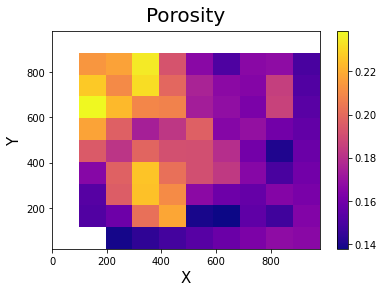

In [8]:
# Make pixelated plot of well porosity
pixelplot(primary_df, cmap='plasma')

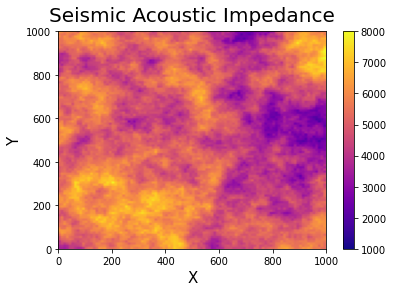

In [18]:
# Make pixelated from the seismic data
plt.imshow(seismic, extent=(0,1000,0,1000), cmap='plasma',
            vmin=1000, vmax=8000, aspect='auto')
plt.colorbar()
plt.xlabel('X', size=15)
plt.ylabel('Y', size=15)
plt.title('Seismic Acoustic Impedance', size=20, pad=10)
plt.show()

In [16]:
seismic.shape

(100, 100)

In [9]:
# Convert seismic data from 2D array to dataframe
x = np.linspace(0, 1000, 100)
y = np.linspace(0, 1000, 100)

x = np.tile(x, 100)
y = np.repeat(y, 100)

seismic_flatten = np.ndarray.flatten(seismic)

secondary_df = pd.DataFrame({'X': x, 'Y': y, 'AI': seismic_flatten})
secondary_df

,X,Y,AI
0,0.00000,0.0,6250.529646
1,10.10101,0.0,6062.088268
2,20.20202,0.0,5729.688467
3,30.30303,0.0,5956.241847
4,40.40404,0.0,5850.904104
...,...,...,...
9995,959.59596,1000.0,5687.758857
9996,969.69697,1000.0,5720.896257
9997,979.79798,1000.0,5763.378850
9998,989.89899,1000.0,5453.696984


## 3. Crossplot between primary and secondary

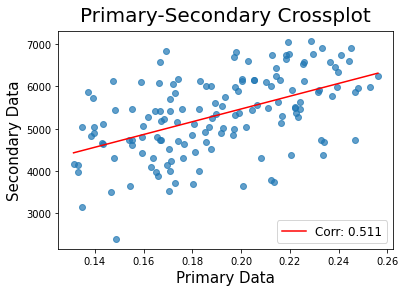

In [11]:
# Cross plot between primary and secondary data
values_interp = correlation(primary_df, secondary_df)

In [12]:
# Put the secondary-on-primary interpolated points to primary dataframe
primary_df['Secondary'] = values_interp

primary_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,X,Y,Porosity,Secondary
0,250.0,50.0,0.139637,4909.339859
1,650.0,750.0,0.170732,3989.916166
2,80.0,669.0,0.244345,6606.848780
3,200.0,150.0,0.167125,4725.947237
4,60.0,929.0,0.216253,5142.346131
...,...,...,...,...
139,260.0,589.0,0.192244,5548.269559
140,190.0,59.0,0.147362,6124.387382
141,90.0,629.0,0.231513,5860.653965
142,190.0,889.0,0.219072,7059.992339


## 4. AutoML implementation

In [13]:
# Train and test data
X = primary_df[['X', 'Y', 'Secondary']]
y = primary_df['Porosity']

X_train, y_train = X, y
X_test = secondary_df

In [19]:
# Make TPOT regressor model
tregr = tpot.TPOTRegressor(n_jobs=7, verbosity=2, generations=20, 
                           warm_start=True, scoring='r2')

In [ ]:
# Fit TPOT regressor
tregr.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/5100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.6776196586998142

Generation 2 - Current best internal CV score: 0.6820231961121352

Generation 3 - Current best internal CV score: 0.6955935501819233

Generation 4 - Current best internal CV score: 0.6955935501819233

Generation 5 - Current best internal CV score: 0.6984485690022899

Generation 6 - Current best internal CV score: 0.720664466939701

Generation 7 - Current best internal CV score: 0.7238925977911921

Generation 8 - Current best internal CV score: 0.7432193989368401

Generation 9 - Current best internal CV score: 0.7432193989368401

Generation 10 - Current best internal CV score: 0.7444966513345469

Generation 11 - Current best internal CV score: 0.7598754949567768

Generation 12 - Current best internal CV score: 0.7795006484449167

Generation 13 - Current best internal CV score: 0.7795006484449167

Generation 14 - Current best internal CV score: 0.7795006484449167

Generation 15 - Current best internal CV score: 0.7795006

In [ ]:
# Best regressor
tregr.fitted_pipeline_

Pipeline(memory=None,
         steps=[('stackingestimator-1',
                 StackingEstimator(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                                     cv=None,
                                                     fit_intercept=True,
                                                     gcv_mode=None,
                                                     normalize=False,
                                                     scoring=None,
                                                     store_cv_values=False))),
                ('maxabsscaler', MaxAbsScaler(copy=True)),
                ('normalizer', Normalizer(copy=True, norm='l1')),
                ('stackingestimator-2',
                 StackingEstimator(estimator=Gr...
                                                                       min_weight_fraction_leaf=0.0,
                                                                       n_estimators=100,
                          

In [ ]:
# Save the best model
# joblib.dump(tregr.fitted_pipeline_, 'TPOTRegressor_PoroAI.pkl')

In [14]:
# Load the pickled model
model = joblib.load('/content/spatial-prediction/TPOTRegressor_PoroAI.pkl')

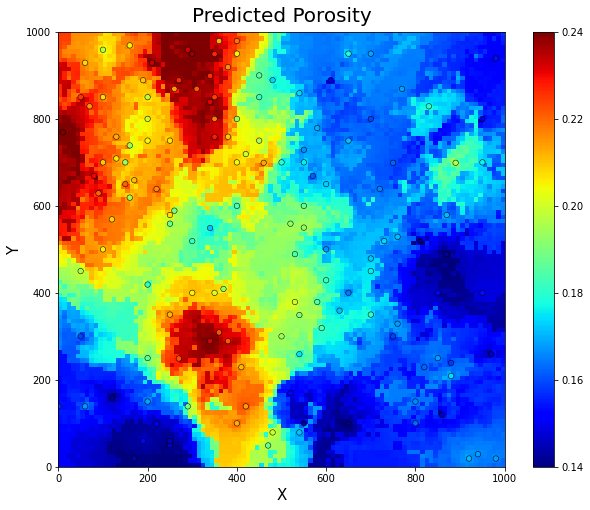

In [34]:
# Predict on secondary data
y_pred = model.predict(X_test)

# Convert the predicted result to dataframe
result_df = pd.DataFrame({'X': secondary_df.iloc[:,0], 'Y': secondary_df.iloc[:,1],
                          'Predicted Porosity': y_pred})

# Make pixelated plot of predicted result
plt.figure(figsize=(10,8))
pixelplot(result_df, nx_grid=100, ny_grid=100, cmap='jet', vmin=0.14, vmax=0.24)

# Overlay with well porosity scatter plot
plt.scatter(primary_df.X, primary_df.Y, c=primary_df.Porosity, 
            s=30, linewidth=0.5, edgecolor='black', cmap='jet')
plt.show()

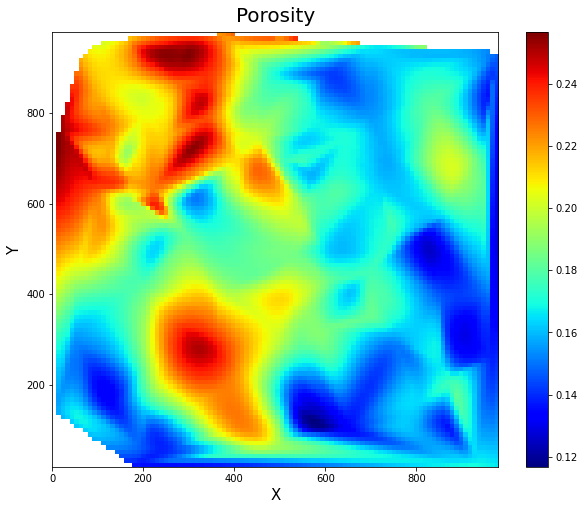

In [40]:
# Compare with interpolation methods
plt.figure(figsize=(10,8))
pixelplot(primary_df.iloc[:,:-1], nx_grid=100, ny_grid=100, gridding='cubic', cmap='jet')

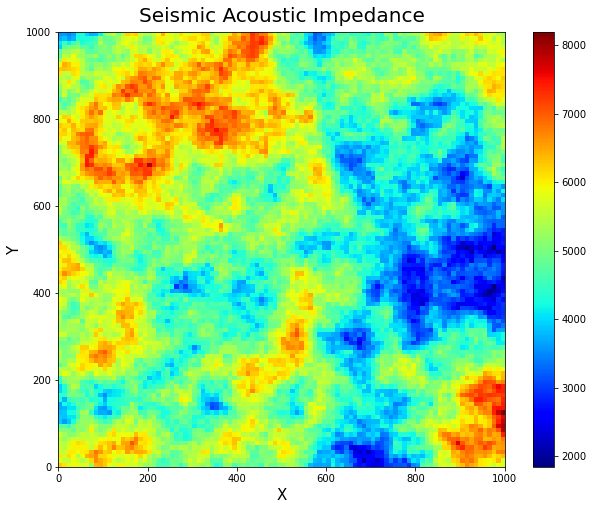

In [33]:
# Pixelated plot of seismic data
secondary_df.columns = ['X', 'Y', 'Seismic Acoustic Impedance']

plt.figure(figsize=(10,8))
pixelplot(secondary_df, nx_grid=100, ny_grid=100, cmap='jet')